# Change point model

Given data about mining disasters in the UK and a hypothesis that changing of laws have made mining safer, we would like to infer when the laws were changed and the rate of disasters before and after the change.

This example demonstrates a marginalised discrete distribution. More details about this example can be found in the STAN reference.

In [1]:
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

import pystan

In [2]:
# Mining Disasters by year in the UK
# https://pymc-devs.github.io/pymc/tutorial.html#an-example-statistical-model

disasters_array =   \
     np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

year = np.arange(1851, 1961 + 1)

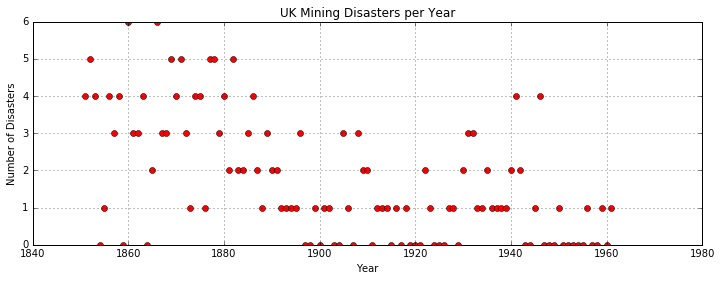

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.set_title("UK Mining Disasters per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Disasters")
ax.plot(year, disasters_array, 'ro')
ax.grid()
fig.show()

In [4]:
model_code = """
data {
    real<lower=0> r_e;
    real<lower=0> r_l;
    int<lower=1> T;
    int<lower=0> D[T];
}

transformed data {
    real log_unif;
    log_unif <- -log(T);
}

parameters {
    real<lower=0> e;
    real<lower=0> l;
}

transformed parameters {
    vector[T] lp;
    lp <- rep_vector(log_unif, T);
    for (s in 1:T)
        for (t in 1:T)
            lp[s] <- lp[s] + poisson_log(D[t], if_else(t < s, e, l));
}

model {
    e ~ exponential(r_e);
    l ~ exponential(r_l);
    increment_log_prob(log_sum_exp(lp));
}
"""
model = pystan.StanModel(model_code=model_code)

In [5]:
data = dict(r_e=1., r_l=1., T=len(disasters_array), D=disasters_array)
fit = model.sampling(data=data)
samples = fit.extract()

In [6]:
def logprob_to_prob(lp):
    pr = np.exp(lp - lp.max(axis=1, keepdims=True))
    pr /= pr.sum(axis=1, keepdims=True)
    return pr

pr_samples = logprob_to_prob(samples['lp'])

pr = pr_samples.mean(axis=0)
pr /= pr.sum()

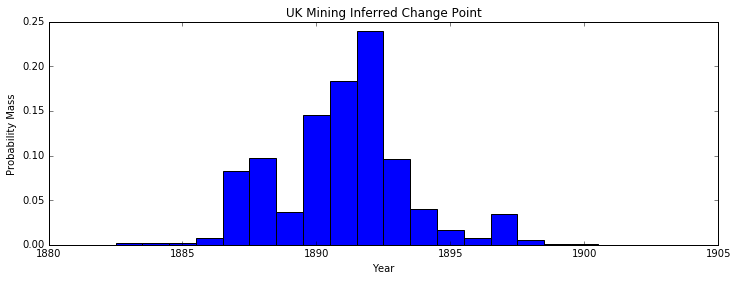

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.set_title('UK Mining Inferred Change Point')
ax.set_xlabel('Year')
ax.set_ylabel('Probability Mass')

ax.bar(year[30:50] - .5, pr[30:50], 1.)
fig.show()

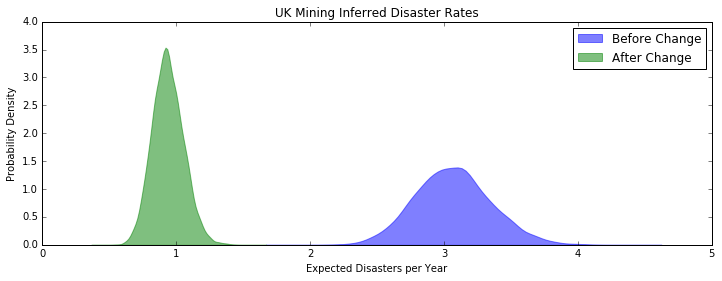

In [8]:
import scipy.stats

def plot_kde_density_1d(d, ax=plt, **kwargs):
    kernel = scipy.stats.gaussian_kde(d)
    mid = d.mean()
    under = d.min() - mid
    over  = d.max() - mid
    x = np.linspace(mid + 1.5*under, mid + 1.5*over, 100)
    ax.fill_between(x, kernel(x), **kwargs)
    
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.set_title('UK Mining Inferred Disaster Rates')
ax.set_xlabel('Expected Disasters per Year')
ax.set_ylabel('Probability Density')

plot_kde_density_1d(samples['e'], ax=ax, label='Before Change', color='b', alpha=.5)
plot_kde_density_1d(samples['l'], ax=ax, label='After Change', color='g', alpha=.5)

ax.legend()
fig.show()